# Nucleus Detection

### Next steps

* Still not sure if by training on non 256x256 data we are improving... Maybe consider just resizing everything to that
    * I think we should check whether number of nuclei (and size of) is propto image size
    * If the number is constant, then should resize.
    * If the number varies, then should do what currently doing (cut)
    * Basically, if larger images are zooms, then we should resize everything. If they are actually larger FOV then we should cut.
* Consider validation with actual iou metric (raises the question of which cutoff to use)
* Consider normalizing output to [0, 1]
* the paper mentions something about how to init network weights
* Setting the weights (for calculating error) I think is pretty important. Could probably think more about that

### Mid term plans

* Data augmentation
* https://www.kaggle.com/ahassaine/pure-image-processing-lb-0-274

# Imports

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [8]:
import data_loaders, net, imcut
import plot_helpers.plot as plot
from evaluations.iou import log_iou, iou_loss
from prepare_submission.cleanup import cleanup
from prepare_submission.submit import write_submission
import helpers as h

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.autograd import Variable
from sklearn import model_selection
from tqdm import tqdm

# Data

In [9]:
train_raw, train_keys_raw = data_loaders.training_images()
summary_masks_raw, weights_raw = data_loaders.masks_and_weights("one_and_two_term_weights")

In [10]:
train_shapes = {}
for i in range(len(train_raw)):
    img = train_raw[i]
    weight = weights_raw[i]
    mask = summary_masks_raw[i]
    if img.shape[0] < 256 or img.shape[1] < 256: raise Exception("We can't handle small training images")
    try:
        train_shapes[img.shape].append((img, weight, mask))
    except:
        train_shapes[img.shape] = [(img, weight, mask)]

In [11]:
train, weights, summary_masks = [], [], []
for shp, images in train_shapes.items():
    y_cut, x_cut = imcut.training_patchify(shp)
    for img_index in range(len(images)):
        for i in range(len(y_cut)):
            for j in range(len(x_cut)):
                train.append(images[img_index][0][y_cut[i]:y_cut[i] + 256,x_cut[j]:x_cut[j] + 256])
                weights.append(images[img_index][1][y_cut[i]:y_cut[i] + 256,x_cut[j]:x_cut[j] + 256])
                summary_masks.append(images[img_index][2][y_cut[i]:y_cut[i] + 256,x_cut[j]:x_cut[j] + 256])

In [12]:
trainT, valid, weightsT, valid_weights, summary_masksT, valid_summary_masks = model_selection.train_test_split(train, weights, summary_masks, test_size=0.2)

trainV, validV = h.tensorfy(trainT), h.tensorfy(valid)
weightsV, valid_weightsV = h.tensorfy(weightsT), h.tensorfy(valid_weights)
summary_masksV, valid_summary_masksV = h.tensorfy(summary_masksT), h.tensorfy(valid_summary_masks)

assert summary_masksV.shape == weightsV.shape and trainV.shape == weightsV.shape
print(summary_masksV.shape, type(trainV))

torch.Size([1779, 1, 256, 256]) <class 'torch.FloatTensor'>


### Sanity check

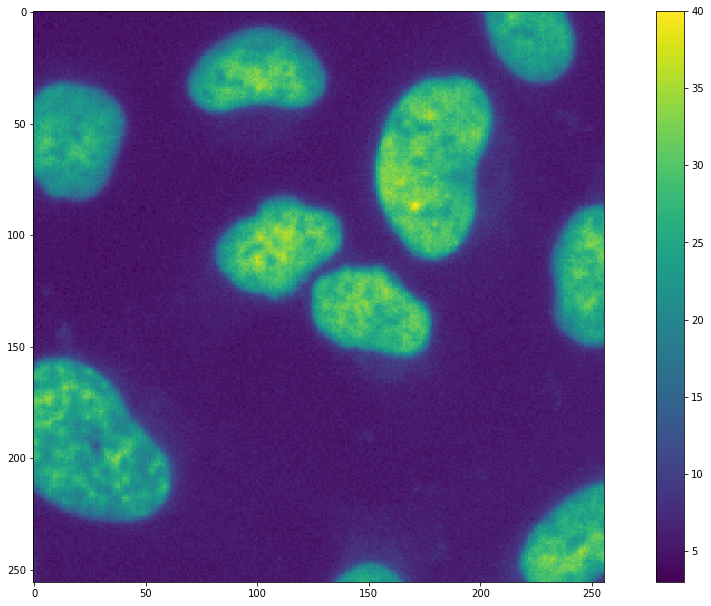

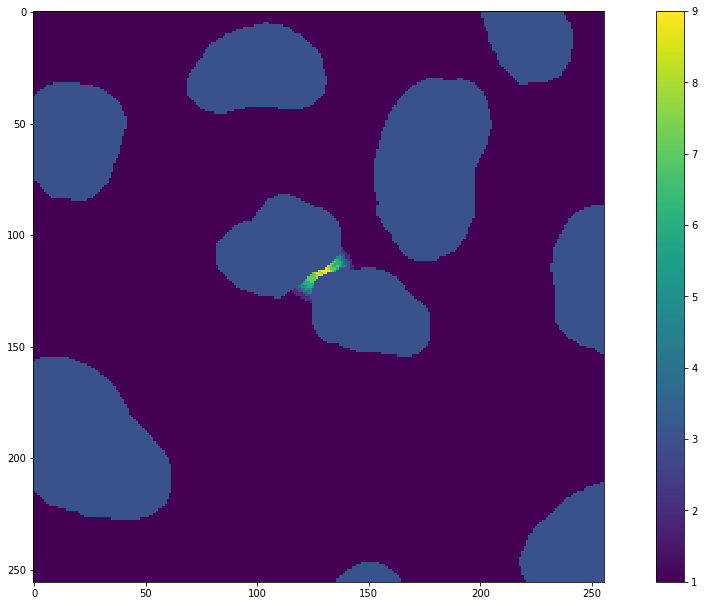

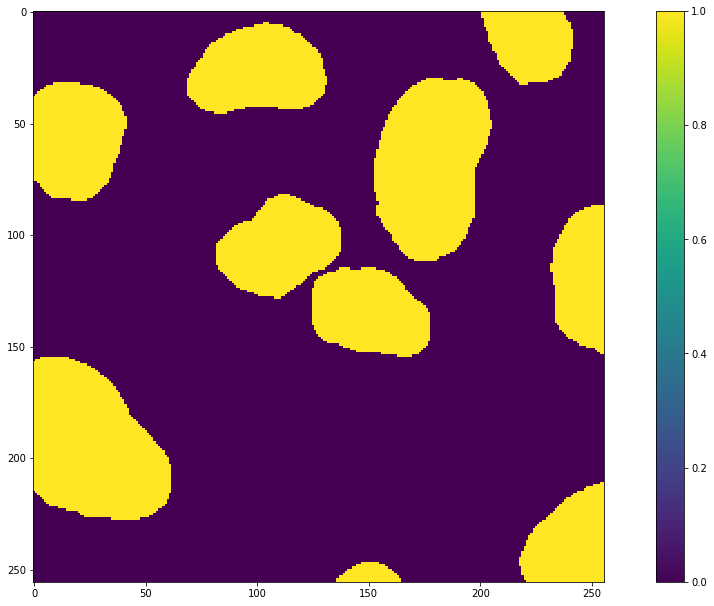

In [12]:
i = 800
plot(trainT[i])
plot(weightsT[i])
plot(summary_masksT[i])

# Exploration

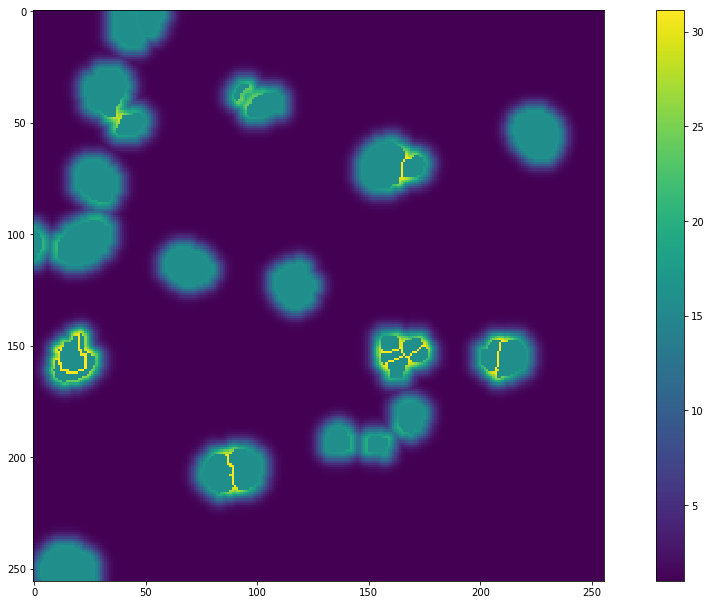

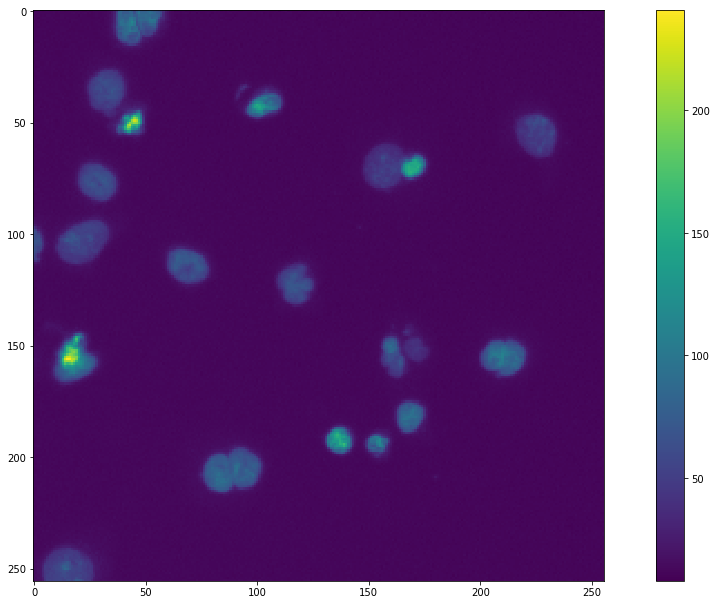

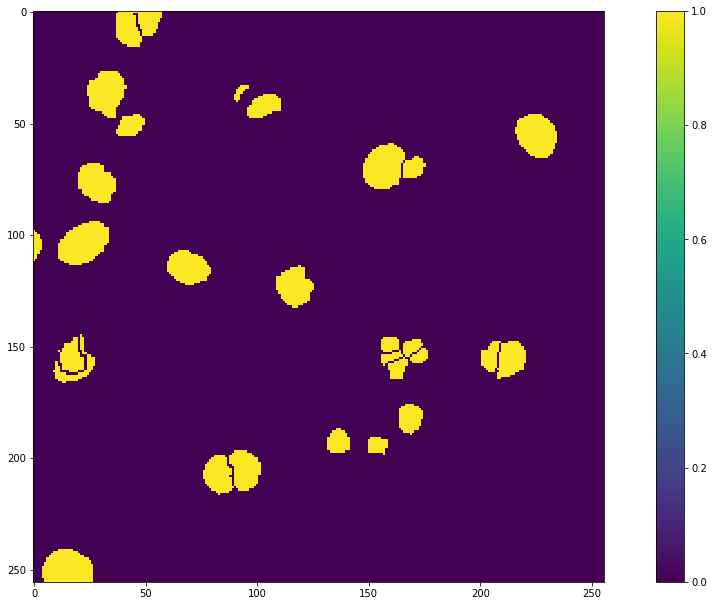

In [13]:
for i in [weights, train, summary_masks]:
    plot.imshow(i[3])


# Train

In [13]:
n = net.u_net().cuda()
# Large momentum because our batch size is small. We want many of the recent images to impact our move.
optimizer = torch.optim.SGD(n.parameters(), lr=0.001, momentum=0.99)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=0, verbose=True)
batchsize = 5
epoch_size = 500
losses = []
epoch_num = 0

In [68]:
for epoch in range(10):
    n.train()
    epoch_num += 1  
    shuffle = torch.randperm(epoch_size)
    t = tqdm(range(0, len(shuffle), batchsize), desc="{} Epoch".format(epoch_num))
    for i in t:
        indexes = shuffle[i:i+batchsize]
        # Define input data
        inp = trainV[indexes]
        inp = torch.nn.ReflectionPad2d((348-256)//2)(inp).cuda()

        # Define expected data and weights
        weight = Variable(weightsV[indexes]).cuda()
        exp = Variable(summary_masksV[indexes]).cuda()

        # Ready net
        optimizer.zero_grad()

        # Run net and get output ready for loss and backgrad
        out = n(inp)[:,:,2:-2,2:-2]
        
        # Calculate loss
        loss = (weight * (exp - out)**2).mean()
        loss.backward()
        optimizer.step()
        losses.append(loss.data.cpu().numpy()[0])
    
    # Validation
    # Should maybe use actual method we are scored on here?
    n.train(False)
    loss = 0
    for i in range(len(validV)):
        inp = validV[i:i+1]
        inp = torch.nn.ReflectionPad2d((348-256)//2)(inp).cuda()
        out = n(inp)[:,:,2:-2,2:-2]

        weight = valid_weightsV[i:i+1].cuda()
        exp = valid_summary_masksV[i:i+1].cuda()
        loss += (weight * (exp - out.data)**2).mean()
    
    # Update LR
    print("LR update")
    print(optimizer.param_groups[0]['lr'])
    scheduler.step(loss)
    print(loss)
    print(optimizer.param_groups[0]['lr'])

3 Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

LR update
0.001
145.72806789170863
0.001


4 Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

LR update
0.001
Epoch     2: reducing learning rate of group 0 to 5.0000e-04.
175.23609908716753
0.0005


5 Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

LR update
0.0005
116.18622385547496
0.0005


6 Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

LR update
0.0005
Epoch     4: reducing learning rate of group 0 to 2.5000e-04.
117.62412401840638
0.00025


7 Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

LR update
0.00025
Epoch     5: reducing learning rate of group 0 to 1.2500e-04.
146.52443655743264
0.000125


8 Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

LR update
0.000125
Epoch     6: reducing learning rate of group 0 to 6.2500e-05.
137.58415556827094
6.25e-05


9 Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

LR update
6.25e-05
100.86671774485148
6.25e-05


10 Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

LR update
6.25e-05
Epoch     8: reducing learning rate of group 0 to 3.1250e-05.
132.0604211660102
3.125e-05


11 Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

LR update
3.125e-05
Epoch     9: reducing learning rate of group 0 to 1.5625e-05.
147.81266415608115
1.5625e-05


11 Epoch: 100%|██████████| 100/100 [00:44<00:00,  2.27it/s]


LR update
1.5625e-05
Epoch    10: reducing learning rate of group 0 to 7.8125e-06.
140.09259451308753
7.8125e-06


# Post train sanity checks

(0, 2)

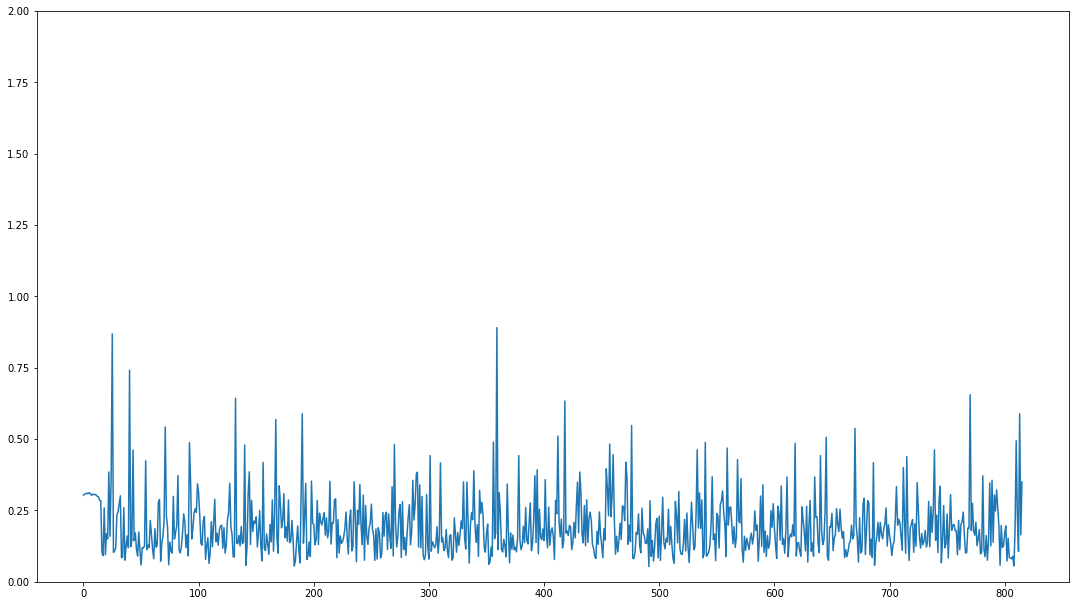

In [202]:
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5) 
ax.plot(losses)
ax.set_ylim(0, 2)

# Validation

In [74]:
# Mostly useful to store results in array
n.train(False)
loss = 0
valid_results = []
for i in range(len(validV)): 
    inp = validV[i:i+1]
    inp = torch.nn.ReflectionPad2d((348-256)//2)(inp).cuda()
    out = n(inp)[:,:,2:-2,2:-2]
    
    valid_results.append(out.data[0][0].cpu().numpy())
    
    weight = valid_weightsV[i:i+1].cuda()
    exp = valid_summary_masksV[i:i+1].cuda()
    loss += (weight * (exp - out.data)**2).mean()
    
print(loss)

140.09259451308753


0.3


/home/christopher/code/ml/data-science-bowl-2018/evaluations/iou.py:60: RuntimeWarning: divide by zero encountered in true_divide
  iou = intersection / union


0.31
0.32
0.33
0.34
0.35000000000000003
0.36000000000000004
0.37000000000000005
0.38000000000000006
0.39000000000000007
0.4000000000000001
0.4100000000000001
0.4200000000000001
0.4300000000000001
0.4400000000000001
0.4500000000000001


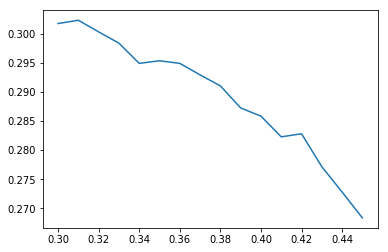

In [70]:
n.train(False)
losses = []
# consider otsu thresholding?
cutoffs = np.arange(0.30, 0.45, 0.01)
for cutoff in cutoffs:
    print(cutoff)
    loss = 0
    for i in range(len(valid_results)):
        pred = cleanup(valid_results[i].cpu().numpy(), cutoff)
        true = valid_summary_masksV[i][0].numpy()
        l = iou_loss(pred, true)
        loss += l
    losses.append(loss / len(valid_results))
plt.plot(cutoffs, losses)

In [75]:
cutoff = 0.32
i = 19
from skimage import filters
print(filters.threshold_otsu(valid_results[i]))

0.298828125


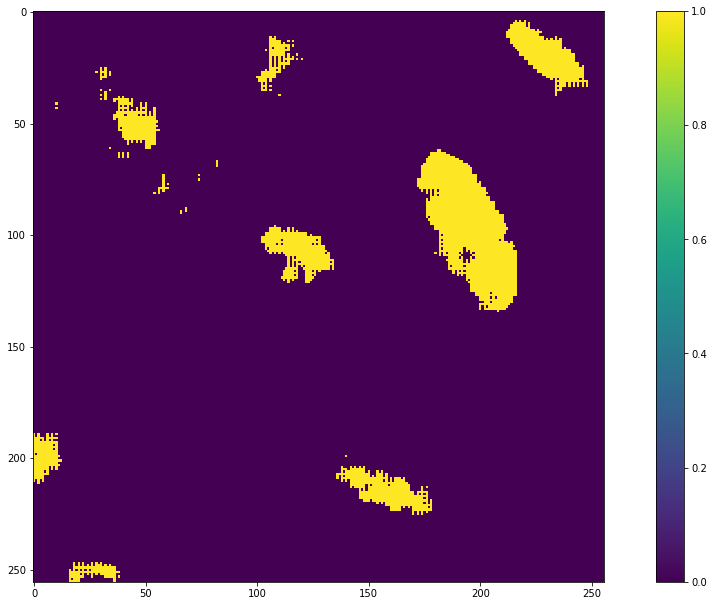

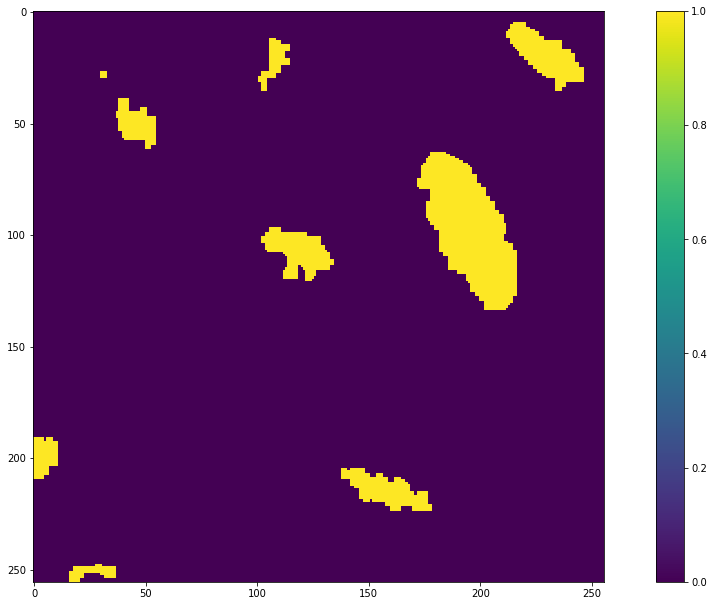

In [67]:
cutoff = 0.32
i = 29
plot.imshow(valid_results[i])
plot.imshow(cleanup(valid_results[i].cpu().numpy(), cutoff))

uint8


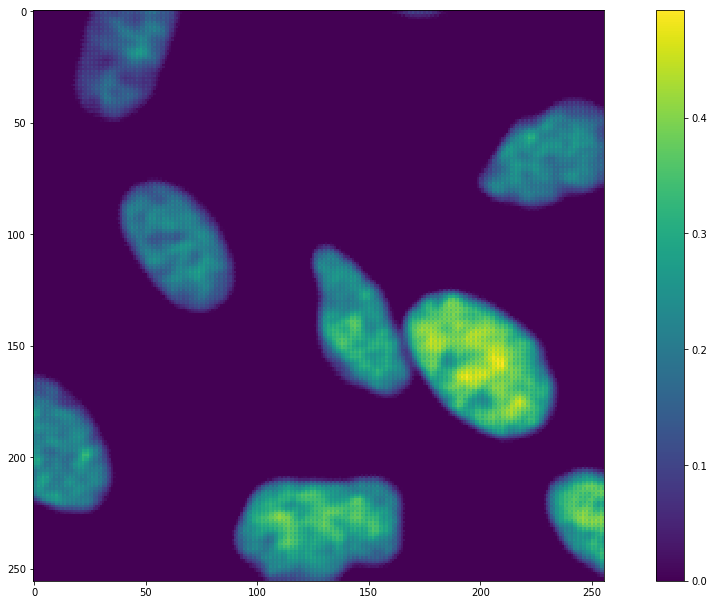

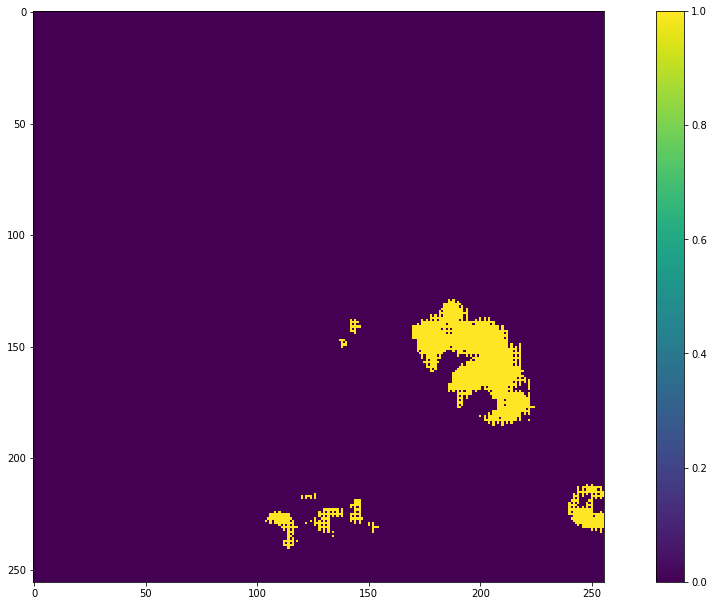

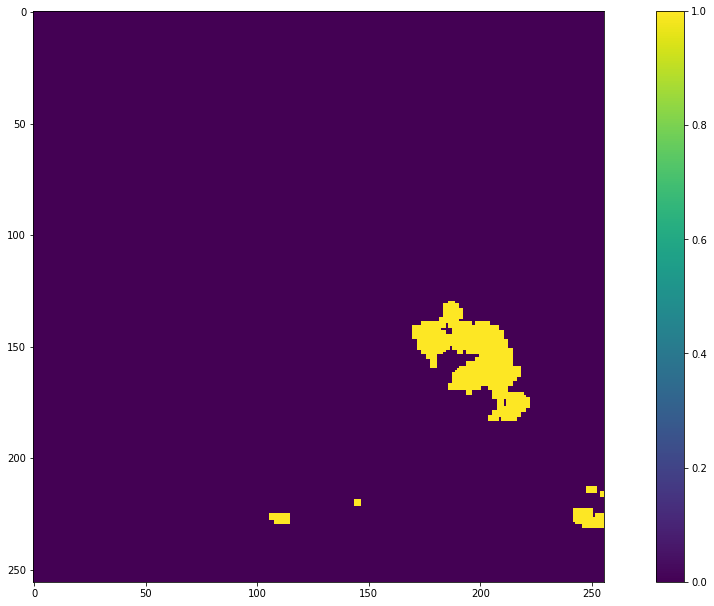

In [35]:
cutoff = 0.35
i = 32
plot.imshow(valid_results[i])
plot.imshow(valid_results[i] > cutoff)
plot.imshow(cleanup(valid_results[i].cpu().numpy(), cutoff))

# Test

In [15]:
test_raw, test_keys_raw = data_loaders.test_images()

In [16]:
shapes = {}
keys = {}
for i in range(len(test_raw)):
    shape = test_raw[i].shape
    try:
        shapes[shape].append(test_raw[i])
        keys[shape].append(test_keys_raw[i])
    except:
        shapes[shape] = [test_raw[i]]
        keys[shape] = [test_keys_raw[i]]

In [17]:
for k, v in shapes.items():
    shapes[k] = h.tensorfy(v)

In [18]:
shapes.keys()

dict_keys([(256, 256), (520, 348), (512, 680), (512, 640), (520, 696), (519, 161), (519, 162), (260, 347), (524, 348), (519, 253), (390, 239)])

In [19]:
n.train(False)
inp_size = 348
results, results_keys = [], []
for shp, images in shapes.items():
    y_cut, x_cut = imcut.patchify(shp)

    for img_index in range(len(images)):
        res = np.zeros(shp)
        for i in range(len(y_cut) - 1):
            for j in range(len(x_cut) - 1):
                 
                height = y_cut[i+1] - y_cut[i]
                width = x_cut[j+1] - x_cut[j]
                inp = images[img_index:img_index+1,:,y_cut[i]:y_cut[i+1],x_cut[j]:x_cut[j+1]]
                orig_shape = inp.shape
                
                width_pad = (inp_size-width)//2
                height_pad = (inp_size-height)//2
                inp = torch.nn.ReflectionPad2d(
                    (width_pad, width_pad, height_pad, height_pad),
                )(inp).cuda()
                assert inp.shape == (1, 1, inp_size, inp_size)
                
                width_unpad = (260 - width) // 2
                height_unpad = (260 - height) // 2
                out = n(inp)[:,:,height_unpad:-height_unpad,width_unpad:-width_unpad]
                assert out.shape == orig_shape
                
                res[y_cut[i]:y_cut[i+1],x_cut[j]:x_cut[j+1]] = out.data
        results.append(res)
        results_keys.append(keys[shp][img_index])

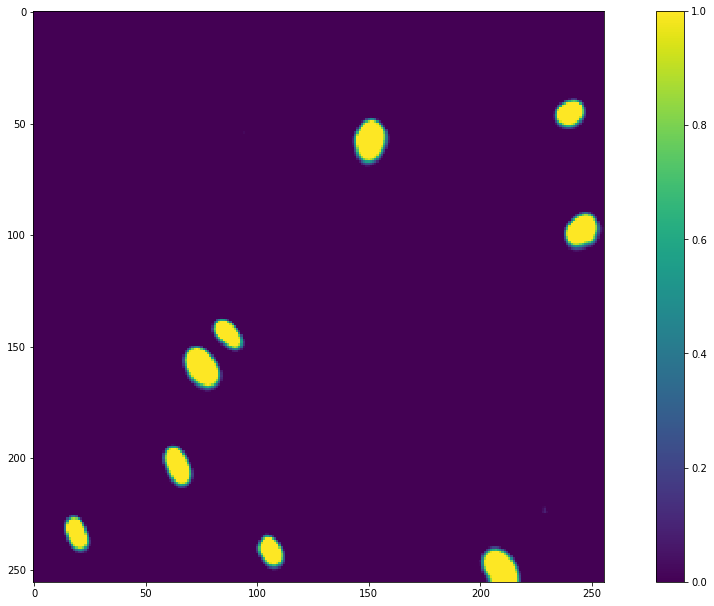

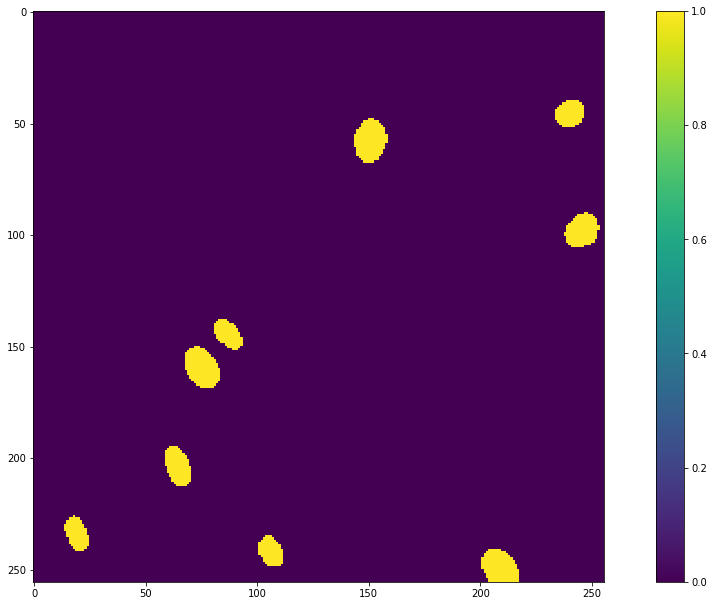

In [206]:
cutoff = 0.33
plot.imshow(results[10])
plot.imshow((results[10] > cutoff).astype(np.int))

In [20]:
write_submission("test_nn_out", [cleanup(i, 0.33) for i in results], results_keys)

Submitting for 65 images


In [ ]:
res